## Recommender Engine Using A Last.fm Music Dataset

This notebook contains all stages of building a recommender engine using a last.fm music dataset. In summary, we will use collaborative filtering algorithms to predict a rating for an artist a user has not listened to. We will use 3 algorithms to implement this prediction:

- Taking the average of ratings, for the particular artist, by other users (this serves as the baseline performance)  
- Using the pearson correlation coefficient to measure similarity between users. Then take weighted average of the ratings by users who are similar to the user in question  
- Using the cosine similarity to measure similarity between users. Then take weighted average of the ratings by users who are similar to the user in question  

In [2]:
# Importing the relevant modules
from __future__ import division 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# init random gen
np.random.seed(2)

In [29]:
# Ignore warnings
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings("ignore")

### Dataset

In [31]:
# Reading in the data
user_artists = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',sep='\t')


In [32]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


### Checking for missing values

Looking at the results of .info() method below, our dataset does not have any missing values.

In [33]:
user_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
userID      92834 non-null int64
artistID    92834 non-null int64
weight      92834 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB


In [34]:
print(user_artists.shape)
print('Number of unique users: %s' % user_artists.userID.nunique())
print('Number of unique artists: %s' % user_artists.artistID.nunique())

(92834, 3)
Number of unique users: 1892
Number of unique artists: 17632


### Rating system

Rating in this dataset(i.e. the 'weight' variable) is based on the number of times a user has listened to an artist. So the values can be anywhere between 1 and 352,698. However, since predicting the exact number of times a user would listen to an artist is not of particular importance, we group 'weight' values into 10 categories and will attempt to predict the category, instead, using the recommender engine.

In [35]:
user_artists.weight.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
10%          37.00000
20%          83.00000
30%         131.00000
40%         188.00000
50%         260.00000
60%         358.00000
70%         506.00000
80%         764.00000
90%        1387.00000
max      352698.00000
Name: weight, dtype: float64

In [52]:
user_artists.loc[user_artists.weight <= 37,'rating'] = 1
user_artists.loc[(user_artists.weight > 37) & (user_artists.weight <= 83),'rating'] = 2
user_artists.loc[(user_artists.weight > 83) & (user_artists.weight <= 131),'rating'] = 3
user_artists.loc[(user_artists.weight > 131) & (user_artists.weight <= 188),'rating'] = 4
user_artists.loc[(user_artists.weight > 188) & (user_artists.weight <= 260),'rating'] = 5
user_artists.loc[(user_artists.weight > 260) & (user_artists.weight <= 358),'rating'] = 6
user_artists.loc[(user_artists.weight > 358) & (user_artists.weight <= 506),'rating'] = 7
user_artists.loc[(user_artists.weight > 506) & (user_artists.weight <= 764),'rating'] = 8
user_artists.loc[(user_artists.weight > 764) & (user_artists.weight <= 1387),'rating'] = 9
user_artists.loc[(user_artists.weight > 1387),'rating'] = 10

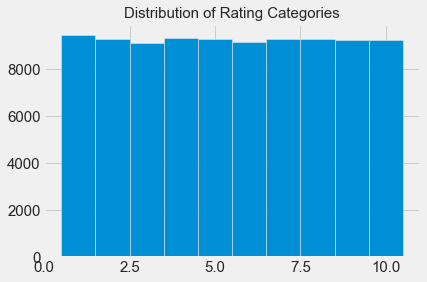

In [37]:
plt.style.use('fivethirtyeight')
plt.hist(user_artists.rating,bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.title("Distribution of Rating Categories",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Generating 80-20 train/test sets 

We do this by putting 20% of each user's ratings in the test set and the remaining 80% in train set. The reason for this is to have as much of the users as we can in both train and test sets. However, this would not be fully possible since some users have only rated one artist.

In [38]:
#The assign_to_set function will be applied to each user's ratings to mark 20% of those records for testing

def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

In [39]:
# Train/test split using groupby 

user_artists['for_testing'] = False
grouped = user_artists.groupby('userID', group_keys=False).apply(assign_to_set)
user_artists_train = user_artists[grouped.for_testing == False]
user_artists_test = user_artists[grouped.for_testing == True]

# Verifying the number of records in train and test sets
print(user_artists.shape)
print(user_artists_train.shape)
print(user_artists_test.shape)
assert len(user_artists_train.index & user_artists_test.index) == 0

(92834, 5)
(74241, 5)
(18593, 5)


### Performance criterion

For this project the performance evaluation criterion is RMSE. There are several other options in the literature as well such as:

- RMSE: $\sqrt{\frac{\sum(\hat y - y)^2}{n}}$
- Precision / Recall / F-scores
- ROC curves
- Cost curves

In [40]:
# This function calculates RMSE

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

### Evaluation

In [41]:
# We will use the function below to evaluate the engines developed below

def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(user_artists_test.userID, user_artists_test.artistID)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = user_artists_test.rating.values
    return compute_rmse(estimated, real)

## Building the Recommender Engine Using Collaborative Filtering

Here we build the engine using collaborative filtering. This means prediction happens by considering other users' rating for the particular item.

### Establishing a baseline performance using average

In [42]:
# Defining a class for the mean-based collaborative filetr 

class CollabMeanReco:
    """ Collaborative filtering using average. """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = user_artists.pivot_table('rating', index='artistID', columns='userID')

    def estimate(self, userID, artistID):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = user_artists_train.userID != userID
        artist_condition = user_artists_train.artistID == artistID
        ratings_by_others = user_artists_train.loc[user_condition & artist_condition]
        
        # If artist was not rated by others, return 5
        if ratings_by_others.empty: 
            return 5.0
        
        # Otherwise return the mean of ratings by others
        else:
            return np.average(ratings_by_others.rating)

In [43]:
# Evaluating the performance of mean based collaborative filter

reco = CollabMeanReco()
reco.learn()
print('RMSE for CollabMeanReco: %s' % evaluate(reco.estimate))

RMSE for CollabMeanReco: 2.946419164790173


### Collaborative Filtering using Pearson Correlation Coefficient

- Pearson correlation

$$ sim(x,y) = \frac{(x - \bar x).(y - \bar y)}{\sqrt{(x - \bar x).(x - \bar x) * (y - \bar y)(y - \bar y)}} $$

In [44]:
# Defining the function that calculates pearson correlation coefficient

def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

In [45]:
# Defining a class for the person based collaborative filetr 

class CollabPearsonReco:
    """ Collaborative filtering using average. """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = user_artists.pivot_table('rating', index='artistID', columns='userID')

    def estimate(self, userID, artistID):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = user_artists_train.userID != userID
        artist_condition = user_artists_train.artistID == artistID
        ratings_by_others = user_artists_train.loc[user_condition & artist_condition]
        
        # If artist was not rated by others, return 5
        if ratings_by_others.empty: 
            return 5.0
        
        ratings_by_others.set_index('userID', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userID]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)

In [46]:
# Evaluating the performance of pearson based collaborative filter

reco = CollabPearsonReco()
reco.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco.estimate))

RMSE for CollabPearsonReco: 2.826735898696825


### Collaborative Filtering using Cosine Similarity

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

In [49]:
def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

In [50]:
# Defining a class for the cosine based collaborative filetr 

class CollabCosineReco:
    """ Collaborative filtering using average. """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = user_artists.pivot_table('rating', index='artistID', columns='userID')

    def estimate(self, userID, artistID):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = user_artists_train.userID != userID
        artist_condition = user_artists_train.artistID == artistID
        ratings_by_others = user_artists_train.loc[user_condition & artist_condition]
        
        # If artist was not rated by others, return 5
        if ratings_by_others.empty: 
            return 5.0
        
        ratings_by_others.set_index('userID', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userID]
        sims = their_profiles.apply(lambda profile: cosine(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)

In [51]:
# Evaluating the performance of cosine based collaborative filter

reco = CollabCosineReco()
reco.learn()
print('RMSE for CollabCosineReco: %s' % evaluate(reco.estimate))

RMSE for CollabCosineReco: 2.948624000682614


The cosine method is performing worse than the Mean method. So the best performing method is Pearson.